#### ¿Dónde está alojada la base de datos?

La base **SQLite** está alojada localmente en un archivo llamado `mi_base.sqlite`.  
No requiere servidor: todo ocurre de forma local.

---

#### ¿Qué motor de base de datos se utiliza?

Se utiliza **SQLite**, un motor ligero ideal para bases de datos **pequeñas y medianas**.  
Es embebido, no necesita configuración de servidor ni instalación adicional.

---

#### ¿Cómo nos conectamos a la base de datos?

Se utiliza el módulo `sqlite3` de Python (incluido en la librería estándar).  
La conexión se realiza con:

```python
conn = sqlite3.connect("mi_base.sqlite")

conn.execute(...)         # Para comandos directos
pd.read_sql(query, conn)  # Para cargar resultados como DataFrame

In [283]:
import sqlite3
import pandas as pd

# Mostrar todas las columnas al imprimir
pd.set_option('display.max_columns', None)

# Leer CSV con pandas
df = pd.read_csv("./archive/properati_argentina_2021.csv")

# Conectar (o crear) base SQLite local
conn = sqlite3.connect(':memory:')

# Cargar el DataFrame a una tabla llamada 'alquileres'
df.to_sql('alquileres', conn, if_exists='replace', index=False)

# Consultar las primeras 5 filas con SQL
query = "SELECT * FROM alquileres LIMIT 15;"
df_head = pd.read_sql(query, conn)

print(df_head)


                          id  start_date    end_date  created_on    latitud  \
0   XZq2dFGxBiboHY3Bo/tqlw==  2021-09-09  2022-01-27  2021-09-09 -38.957632   
1   8afoK+yMH/rnnlYiktwgNA==  2021-09-09  2021-10-23  2021-09-09 -34.888878   
2   iVaG5rBB47dd1Ya4BMXREA==  2021-09-09  2022-03-09  2021-09-09 -32.488717   
3   QE1QVMWKAHWkd0qT0FtPWA==  2021-09-09  2022-01-27  2021-09-09 -34.900165   
4   tJ5lSk7IysG/71OGhacNZA==  2021-09-09  2022-01-27  2021-09-09 -38.954528   
5   F9tamlHF5c8kGM6XRTsCKQ==  2021-09-09  2022-01-27  2021-09-09 -34.859680   
6   NqZ7NCaGZKarCdU/V0vHfw==  2021-09-09  2021-09-14  2021-09-09        NaN   
7   gRTl4HxCqiGIwGRq0r1oag==  2021-09-09  2022-01-05  2021-09-09        NaN   
8   Y8n0DpI7wgglQ6QISaTB4g==  2021-09-09  2021-09-10  2021-09-09 -34.901935   
9   HMt6tiEI+xILu5W6cjGdiw==  2021-09-09  2021-10-28  2021-09-09 -34.866268   
10  Fygm+8UhdUE+YJPBjTgz/A==  2021-09-09  2022-01-27  2021-09-09 -31.365005   
11  tKR6OiTB7vXHDojuj3iPuQ==  2021-09-09  2021-09-29

Realizamos un análisis porcentual de datos faltantes por columna, teniendo en cuenta el siguiente criterio:


| % de valores faltantes | Acción                    |
|------------------------|-----------------------------------------------------|
| > 50%                  | Eliminar la columna                                 |
| 20% - 50%              | Evaluar si imputar o conservar según relevancia     |
| < 20%                  | Imputar los valores faltantes                       |
| 0% - 5%                | No es preocupante |


In [263]:
filas_totales = df.shape[0]
porcentaje_faltante_columna = (df.isna().sum() / filas_totales) * 100

# Imprime los porcentajes de faltantes por columna
print((porcentaje_faltante_columna.round(2).astype(str) + " %"))


id                            0.0 %
start_date                    0.0 %
end_date                      0.0 %
created_on                    0.0 %
latitud                      8.78 %
longitud                     8.78 %
place_l2                      0.0 %
place_l3                     4.89 %
place_l4                    69.79 %
place_l5                    99.47 %
place_l6                    100.0 %
operation                     0.0 %
property_type                 0.0 %
property_rooms              19.92 %
property_bedrooms           25.22 %
property_surface_total      13.55 %
property_surface_covered     7.01 %
property_price               3.91 %
property_currency            4.03 %
property_title                0.0 %
dtype: object


Elimino duplicados

In [264]:
# Eliminar duplicados en la tabla SQLite usando SQL y mostrar porcentaje eliminado

# Contar registros antes
total_antes = pd.read_sql("SELECT COUNT(*) as c FROM alquileres", conn)['c'][0]

# Eliminar duplicados en la tabla 'alquileres'
sql = """
DELETE FROM alquileres
WHERE rowid NOT IN (
    SELECT MIN(rowid)
    FROM alquileres
    GROUP BY property_title, place_l2, place_l3, property_price, property_type, latitud, longitud
);
"""
conn.executescript(sql)
conn.commit()

# Contar registros después y recargar DataFrame
total_despues = pd.read_sql("SELECT COUNT(*) as c FROM alquileres", conn)['c'][0]
df = pd.read_sql("SELECT * FROM alquileres", conn)

eliminados = total_antes - total_despues
porcentaje_eliminado = (eliminados / total_antes) * 100 if total_antes > 0 else 0

print(f"Registros después de eliminar duplicados: {total_despues}")
print(f"Registros eliminados: {eliminados} ({porcentaje_eliminado:.2f}%)")

Registros después de eliminar duplicados: 403118
Registros eliminados: 57036 (12.39%)


Análisis porcentual de datos faltantes por fila

In [265]:
filas_totales = df.shape[1]  # número de columnas

porcentaje_faltante_fila = (df.isna().sum(axis=1) / filas_totales) * 100

print(porcentaje_faltante_fila.round(2).astype(str) + " %")

0         40.0 %
1         20.0 %
2         30.0 %
3         30.0 %
4         25.0 %
           ...  
403113    20.0 %
403114    20.0 %
403115    35.0 %
403116    40.0 %
403117    20.0 %
Length: 403118, dtype: object


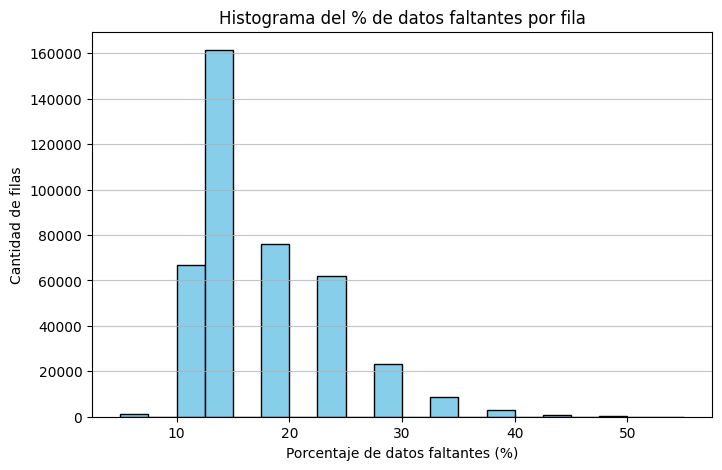

In [266]:
import matplotlib.pyplot as plt

filas_totales = df.shape[1]  # número de columnas

porcentaje_faltante_fila = (df.isna().sum(axis=1) / filas_totales) * 100

plt.figure(figsize=(8,5))
plt.hist(porcentaje_faltante_fila, bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma del % de datos faltantes por fila')
plt.xlabel('Porcentaje de datos faltantes (%)')
plt.ylabel('Cantidad de filas')
plt.grid(axis='y', alpha=0.75)
plt.show()

Selecciono las columnas con las que me interesa trabajar y además descarto las columnas con % de faltante mayor al 50%

In [267]:
query = """
SELECT 
    latitud,
    longitud,
    place_l2,
    place_l3,
    operation,
    property_type,
    property_rooms,
    property_bedrooms,
    property_surface_total,
    property_surface_covered,
    property_price,
    property_currency,
    property_title
FROM alquileres;
"""

df = pd.read_sql(query, conn)


### Análisis de Outliers

Procedemos a hacer un análisis de outliers en la variable "precio", para esto calculamos el primer cuartil (Q1) y el tercer cuartil (Q3) de la distribución de precios, y a partir de ellos obtenemos el rango intercuartílico (IQR = Q3 - Q1).

Luego, extraemos las filas donde el precio está fuera de estos límites (por debajo del límite inferior o por encima del superior) para identificar los valores extremos.

In [268]:
# Calcular Q1 y Q3 de la columna 'precio'
q1 = df['property_price'].quantile(0.25)
q3 = df['property_price'].quantile(0.75)
iqr = q3 - q1

# Calcular límites para detectar outliers
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

print(f"Límite inferior: {lower_bound}, Límite superior: {upper_bound}")

query = f"""
SELECT *
FROM alquileres
WHERE property_price < {lower_bound} OR property_price > {upper_bound}
"""
outliers_df = pd.read_sql(query, conn)

Límite inferior: -184500.0, Límite superior: 427500.0


Grafico el IQR (que representa la dispersión central del conjunto de datos):

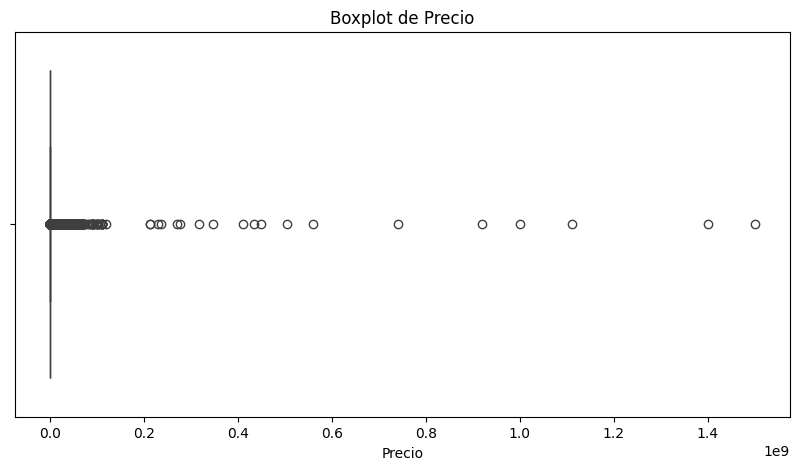

In [269]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x=df['property_price'])
plt.title('Boxplot de Precio')
plt.xlabel('Precio')
plt.show()

Nota: Seguir limpiando en torno a los outliers

### Analisis de inconsistencias

Realizamos un análisis de datos incoherentes en nuestro dataset y vemos cuantos nos afectaría eliminar dichos datos, en particular, los datos a analizar serían los siguientes:

1. Registros sin rooms y sin superficie total válida.

2. Registros con cantidad máxima de habitantes negativa.

3. Registros sin dormitorios pero con más de un ambiente.

4. Registros donde la superficie útil supera a la total por más de 1 m².

5. Registros con superficie total y útil menor o igual a cero.

6. Registros con más dormitorios que ambientes + 2.

7. Registros con ambientes pero sin datos de superficie (útil o total).

In [270]:
# Contar registros antes
cursor = conn.execute("SELECT COUNT(*) FROM alquileres")
total_antes = cursor.fetchone()[0]

# Eliminar inconsistencias
query_delete_inconsistencias = """
DELETE FROM alquileres
WHERE
    property_rooms < 1 AND (property_surface_total IS NULL OR property_surface_total <= 0)
    OR (property_bedrooms = 0 AND property_rooms > 1)
    OR (property_surface_total - property_surface_covered < 0 AND ABS(property_surface_total - property_surface_covered) > 1)
    OR property_surface_total <= 0 
    OR property_surface_covered <= 0
    OR property_bedrooms > property_rooms + 2
    OR (property_rooms > 0 AND (property_surface_covered IS NULL OR property_surface_total IS NULL))
    OR property_price = 0;
"""
conn.execute(query_delete_inconsistencias)
conn.commit()

# Contar registros después
cursor = conn.execute("SELECT COUNT(*) FROM alquileres")
total_despues = cursor.fetchone()[0]

# Cargar DataFrame filtrado
query_filtrado = "SELECT * FROM alquileres"
df_filtrado = pd.read_sql(query_filtrado, conn)

# Calcular y mostrar porcentaje eliminado
eliminados = total_antes - total_despues
porcentaje_eliminado = (eliminados / total_antes) * 100 if total_antes > 0 else 0

print(f"Registros eliminados: {eliminados} ({porcentaje_eliminado:.2f}%)")

Registros eliminados: 57911 (14.37%)


Observamos que eliminamos aproximadamente un 15% de los datos, lo cual nos parece aceptable para nuestra transformación posterior

### Normalización de datos

Analizamos que las columnas place_l2 y place_l3 estén siempre bien escritas. Por ejemplo que no haya diferencias del estilo 'laplata', 'La plata', 'La Plata', etc

In [271]:
# Listar los valores únicos de place_l2
valores = pd.read_sql("SELECT DISTINCT place_l2 FROM alquileres WHERE place_l2 IS NOT NULL", conn)
print(valores['place_l2'].tolist())

['Montevideo', 'Entre Ríos', 'Maldonado', 'Bs.As. G.B.A. Zona Norte', 'Córdoba', 'Mendoza', 'Neuquén', 'Capital Federal', 'Canelones', 'Misiones', 'Santa Fe', 'Bs.As. G.B.A. Zona Oeste', 'Salta', 'Bs.As. G.B.A. Zona Sur', 'Buenos Aires Interior', 'San Juan', 'Michigan', 'Buenos Aires Costa Atlántica', 'Chubut', 'Tucumán', 'Río Negro', 'Corrientes', 'La Pampa', 'Colonia', 'San Luis', 'Jujuy', 'Florida', 'Tierra Del Fuego', 'Santiago Del Estero', 'Santa Catarina', 'Chaco', 'Rocha', 'Catamarca', 'Rio Grande do Norte', 'Santa Cruz', 'São Paulo', 'Maryland', 'Miami', 'La Rioja', 'Pennsylvania']


In [272]:
from rapidfuzz import fuzz
import pandas as pd

def agrupar_similares(conn, columna, umbral=85):
    # Obtener valores únicos de la columna
    query = f"SELECT DISTINCT {columna} FROM alquileres WHERE {columna} IS NOT NULL"
    valores = pd.read_sql(query, conn)
    valores_unicos = valores[columna].dropna().unique()
    
    grupos_similares = {}
    for val in valores_unicos:
        if any(val in g for g in grupos_similares.values()):
            continue
        similares = [v for v in valores_unicos if fuzz.ratio(val, v) >= umbral]
        grupos_similares[val] = similares

    # Mostrar grupos
    for clave, grupo in grupos_similares.items():
        if len(grupo) > 1:
            print(f"{columna} - {clave}: {grupo}")

# Usar la función para place_l2 y place_l3
agrupar_similares(conn, 'place_l2')
agrupar_similares(conn, 'place_l3')

place_l2 - Bs.As. G.B.A. Zona Norte: ['Bs.As. G.B.A. Zona Norte', 'Bs.As. G.B.A. Zona Oeste', 'Bs.As. G.B.A. Zona Sur']
place_l3 - Pilar: ['Pilar', 'Pila']
place_l3 - Flores: ['Flores', 'Floresta']
place_l3 - Barracas: ['Barracas', 'Barrancas']
place_l3 - Monteros: ['Monteros', 'Morteros']
place_l3 - La Caldera: ['La Caldera', 'La Calera']
place_l3 - Gualeguaychú: ['Gualeguaychú', 'Gualeguay']
place_l3 - San Cristobal: ['San Cristobal', 'San Cristóbal']
place_l3 - General San Martín: ['General San Martín', 'Villa General San Martín']
place_l3 - Las Tapias: ['Las Tapias', 'Las Talitas']
place_l3 - Capilla del Rosario: ['Capilla del Rosario', 'Villa del Rosario']
place_l3 - Cariló: ['Cariló', 'Catriló']
place_l3 - San Antonio de Areco: ['San Antonio de Areco', 'San Antonio de Arredondo']
place_l3 - General Alvear: ['General Alvear', 'General Alvarado']
place_l3 - Villa de María: ['Villa de María', 'Villa María']


Vemos que hay valores por corregir...

In [273]:
query = """
UPDATE alquileres SET place_l3 = 'San Cristobal' WHERE place_l3 = 'San Cristóbal';
"""
conn.executescript(query)
conn.commit()

Realizo una normalización de localidades

In [274]:
# Crear tabla de localidades (si no existe)
conn.execute("""
CREATE TABLE IF NOT EXISTS localidades (
    id_localidad INTEGER PRIMARY KEY AUTOINCREMENT,
    nombre TEXT,
    provincia TEXT,
    UNIQUE(nombre, provincia)
)
""")
conn.commit()

Inserto en la tabla todas las combinaciones únicas de localidad y provincia que aparecen en mi tabla.

In [275]:
# Insertar localidades únicas desde alquileres
conn.execute("""
INSERT OR IGNORE INTO localidades (nombre, provincia)
SELECT DISTINCT place_l3, place_l2
FROM alquileres
WHERE place_l3 IS NOT NULL AND place_l2 IS NOT NULL
""")
conn.commit()

Agrego una columna id_localidad en la tabla alquileres para guardar la referencia a la localidad normalizada.

In [276]:
# Agregar columna id_localidad (si no existe)
try:
    conn.execute("ALTER TABLE alquileres ADD COLUMN id_localidad INTEGER")
except Exception:
    pass  # Si ya existe, ignora el error

Para cada fila de alquileres, busco el id de la localidad correspondiente y lo guardo en la nueva columna; haciendo que las columnas place_l2 y place_l3 ya no sean necesarias

In [277]:
# Actualizar id_localidad en alquileres
conn.execute("""
UPDATE alquileres
SET id_localidad = (
    SELECT id_localidad FROM localidades
    WHERE localidades.nombre = alquileres.place_l3
      AND localidades.provincia = alquileres.place_l2
)
WHERE place_l3 IS NOT NULL AND place_l2 IS NOT NULL
""")
conn.commit()

In [ ]:
# Persistir ambas tablas 'alquileres' y 'localidades' en el archivo mi_base.sqlite

# Abrir conexión al archivo en disco
conn_disk = sqlite3.connect("/home/milton/Desktop/Bases de datos/TP-BDD-1C2025/mi_base.sqlite")

query = """
SELECT 
    latitud,
    longitud,
    place_l2,
    place_l3,
    operation,
    property_type,
    property_rooms,
    property_bedrooms,
    property_surface_total,
    property_surface_covered,
    property_price,
    property_currency,
    property_title,
    id_localidad
FROM alquileres;
"""

df = pd.read_sql(query, conn)

# Ver si se persistió la limpieza
 
# Persistir en el archivo .sqlite
conn_disk = sqlite3.connect("/home/milton/Desktop/Bases de datos/TP-BDD-1C2025/mi_base.sqlite")
df.to_sql('alquileres', conn_disk, if_exists='replace', index=False)

# Persistir localidades igual que antes
localidades_df = pd.read_sql("SELECT * FROM localidades", conn)
localidades_df.to_sql('localidades', conn_disk, if_exists='replace', index=False)

conn_disk.commit()
conn_disk.close()
print("Tablas 'alquileres' y 'localidades' persistidas en mi_base.sqlite")

Tablas 'alquileres' y 'localidades' persistidas en mi_base.sqlite
